# Python Tutorial, Part 1: Basic Plotting
## Making synoptic plots using archived GFS model analyses from NCEI THREDDS server

#### Created by Massey Bartolini, last updated 24 Oct 2020
<hr/>

### Overview of steps to make a plot 
<ol>
    <li> Get data </li>
    <li> Make calculation (if field not already available) </li>
    <li> Make a plot </li> 
    <li> Plot geography layers and data </li>
    <li> Add labels and legend </li>
</ol>

### General python package requirements
<ul>
    <li> numpy (array handing, calculations) </li>
    <li> matplotlib (general plotting) </li>
    <li> datetime (handling dates and times) </li>
    <li> xarray (data access and viewing of multidimensional 3D+ data) </li>
    <li> cartopy (geographic plotting), need v0.18+ here  </li> 
    <li> metpy (meteorology calculations) </li>
</ul>

In [1]:
#List of python imports
import xarray as xr
from datetime import datetime, timedelta
import matplotlib as mpl
#mpl.use('Agg') #use different backend to prevent having to open an X-window (uncomment this if using as a python script instead of a jupyter notebook)
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
import os

In [2]:
#Good idea to check which versions of python libraries you are using, 
#especially for the mapping library named cartopy which is still under development (replacing an older library called basemap)
import cartopy as cpy #don't need these imports after checking the version number here, can delete this code block afterwards
import metpy as mpy
!python --version
print ('NumPy', np.__version__)
print ('Matplotlib', mpl.__version__)
print ('XArray', xr.__version__)
print ('Cartopy', cpy.__version__)
print ('MetPy', mpy.__version__)

Python 3.6.7
NumPy 1.18.5
Matplotlib 3.2.2
XArray 0.16.0
Cartopy 0.18.0
MetPy 0.12.2


In [3]:
#Accessing GFS analysis data from NCEI THREDDS server

#Select date to view (some interesting dates below)
model_init=datetime(2012,10,29,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2017,3,15,0)  #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2016,1,23,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2019,12,2,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2019,3,13,12) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2011,4,27,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#model_init=datetime(2012,6,29,18) #Initialization time of model in UTC (YYYY, MM, DD, HH)


#Use format-string (f-string) notation to update the url automatically using model_init above
#Also using strftime formatting syntax here (the colon and percentage signs after the date variable, "model_init :%Y%m")
#to retrieve just the parts of the date needed for the url (see https://strftime.org/)
data_url=f'https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/{model_init:%Y%m}/{model_init:%Y%m%d}/gfsanl_4_{model_init:%Y%m%d}_{model_init:%H%M}_000.grb2'

#Recent (last ~2 weeks) GFS analyses are in a different directory
#model_init=datetime(2020,10,17,0) #Initialization time of model in UTC (YYYY, MM, DD, HH)
#data_url=f'https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files/{model_init:%Y%m}/{model_init:%Y%m%d}/gfs_4_{model_init:%Y%m%d}_{model_init:%H%M}_000.grb2'

#Open a connection to a remote server's data (doesn't download any data yet until you specify a variable to load)
ds=xr.open_dataset(data_url)

In [4]:
#View dataset summary before downloading some variables
#xarray package has exceptionally nice handing of multi-dimensional data: 
#with Datasets (contains all data in file), DataArrays (individual variables), data coordinates, 
#dimensions, and associated attributes (metadata)
#See http://xarray.pydata.org/en/stable/data-structures.html
#This makes it really easy to view, subset, and do calculations on data compared to older python packages,
#with fewer coding mistakes!
ds

<xarray.Dataset>
Dimensions:                                                                   (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 1, isobaric1: 6, isobaric2: 21, isobaric3: 26, isobaric4: 2, isobaric5: 25, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1)
Coordinates:
  * lat                                                                       (lat) float32 ...
  * lon                                                                       (lon) float32 ...
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * height_above_ground_layer                                                 (height_above_ground_layer) float32 ...
  * sigma                                                                     (sigma) float32 ...
  * height_above_ground                                                       (height_above_ground) float32 ...
  * depth_below_surface_layer                                                 (depth_below_surface_layer) float32 ...
  * pressure_difference_layer                                                 (pressure_difference_layer) float32 ...
  * isobaric                                                                  (isobaric) float32 ...
  * height_above_ground1                                                      (height_above_ground1) float32 ...
  * height_above_ground2                                                      (height_above_ground2) float32 ...
  * isobaric1                                                                 (isobaric1) float32 ...
  * isobaric2                                                                 (isobaric2) float32 ...
  * altitude_above_msl                                                        (altitude_above_msl) float32 ...
  * height_above_ground3                                                      (height_above_ground3) float32 ...
  * height_above_ground_layer1                                                (height_above_ground_layer1) float32 ...
  * pressure_difference_layer1                                                (pressure_difference_layer1) float32 ...
  * isobaric3                                                                 (isobaric3) float32 ...
  * isobaric4                                                                 (isobaric4) float32 ...
  * pressure_difference_layer2                                                (pressure_difference_layer2) float32 ...
  * sigma_layer                                                               (sigma_layer) float32 ...
  * height_above_ground4                                                      (height_above_ground4) float32 ...
  * potential_vorticity_surface                                               (potential_vorticity_surface) float32 ...
  * isobaric5                                                                 (isobaric5) float32 ...
Dimensions without coordinates: depth_below_surface_layer_bounds_1, height_above_ground_layer1_bounds_1, height_above_ground_layer_bounds_1, pressure_difference_layer1_bounds_1, pressure_difference_layer2_bounds_1, pressure_difference_layer_bounds_1, sigma_layer_bounds_1
Data variables:
    LatLon_Projection                                                         int32 ...
    height_above_ground_layer_bounds  

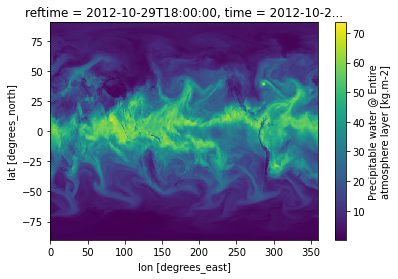

In [5]:
#Quick plots to visualize some variables (no geography yet)
ds['Precipitable_water_entire_atmosphere_single_layer'].isel(time=0).plot() #selecting time index zero

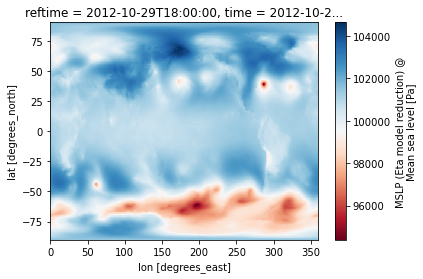

In [6]:
ds['MSLP_Eta_model_reduction_msl'].isel(time=0).plot(cmap=plt.cm.RdBu) #overriding default colormap

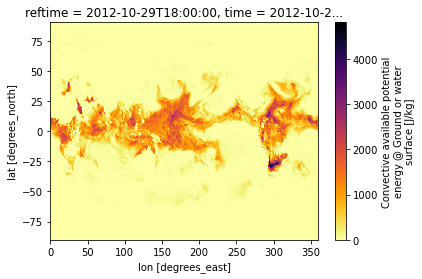

In [7]:
ds['Convective_available_potential_energy_surface'].isel(time=0).plot(cmap=plt.cm.inferno_r) #overriding default colormap, using a reversed version of inferno cmap (_r suffix causes automatic reversal of default)

### Brief geographic plotting tutorial using cartopy

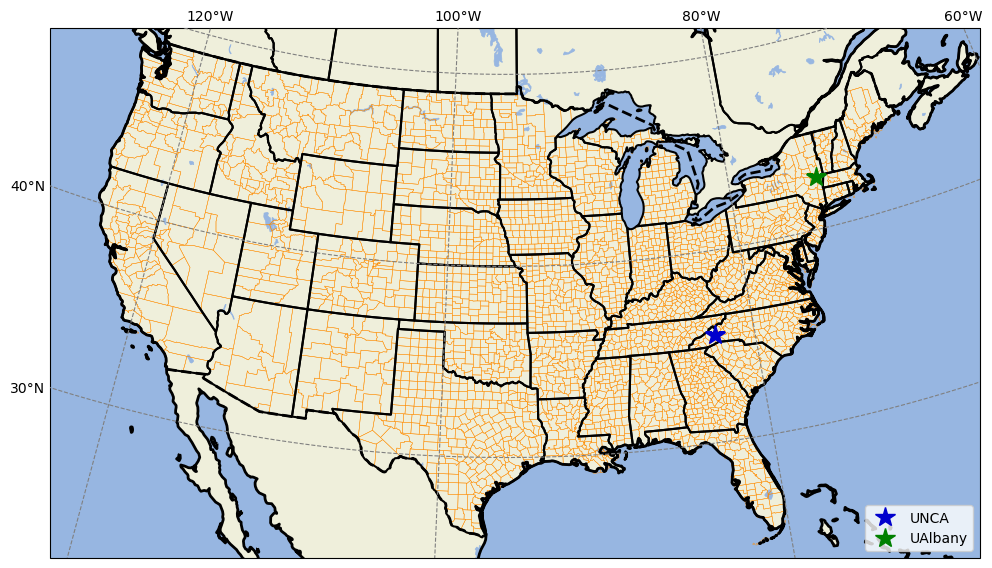

In [8]:
#Now do a plot with only geography as an example

#Select a projection from the list here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
#I typically use either LambertConformal() for CONUS/regional maps or PlateCarree() for very local maps
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj}) #Make a plot with resolution of 100 dpi, figure size of 12"x9"

#Download and plot geography

#Older version of cartopy syntax (still works, just pretty verbose)
#geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
#geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
#ocean=NaturalEarthFeature(category='physical',scale=geog_scale,name='ocean',edgecolor='face',facecolor=cfeature.COLORS['water'])
#ax.add_feature(ocean)
#land=NaturalEarthFeature(category='physical',scale=geog_scale,name='land',edgecolor='face',facecolor=cfeature.COLORS['land'])
#ax.add_feature(land)
#countries=NaturalEarthFeature(category='cultural',scale=geog_scale,facecolor='none',name='admin_0_countries')
#ax.add_feature(countries,linewidth=2,edgecolor=geog_color,zorder=3)
#coastlines=NaturalEarthFeature(category='physical',scale=geog_scale,name='coastline')
#ax.add_feature(coastlines,linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
#states=NaturalEarthFeature(category='cultural',scale=geog_scale,facecolor='none',name='admin_1_states_provinces_lines')
#ax.add_feature(states,linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3)
#lakes=NaturalEarthFeature(category='physical',scale=geog_scale,facecolor='none',name='lakes')
#ax.add_feature(lakes,edgecolor=geog_color,linewidth=1.5,facecolor=cfeature.COLORS['water']) #Filled lakes
#ax.add_feature(lakes,edgecolor=geog_color,linewidth=1.5,facecolor='none',zorder=3) #Lake outlines only

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='0.5',zorder=2.9,linewidth=0.5) #US counties

#Newer version of cartopy syntax
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#cartopy doesn't have a US counties layer, but MetPy does
ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Note: layer features are displayed in the order they are plotted, with filled fields generally set below contours/lines, and contours/lines set below points and text
#but you can modify this with the zorder argument (higher zorder = plotted on top)
#with the defaults being zorder=1 for filled fields, zorder=2 for contours, zorder=3 for points

#Good extent for CONUS plot using rectangular PlateCarree projection
#ax.set_extent([-126,-66,23,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent


#Optional: plot lat/lon lines (only recently available in cartopy for non-rectangular projections, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=5)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot some locations
ax.plot(-82.566324, 35.615969,'*',markersize=15,color='mediumblue',label='UNCA',transform=ccrs.PlateCarree(),zorder=4)
ax.plot(-73.8235054, 42.6860633,'*',markersize=15,color='green',label='UAlbany',transform=ccrs.PlateCarree(),zorder=4)

#Note that all plotting commands for data using lat/lon must include the transform=ccrs.PlateCarree() argument, 
#this transforms the data from lat/lon coordinates into map x/y coordinates 
#which is needed to correctly overlay the data with the geography

ax.legend(loc='lower right')

#Try playing around with the following to get a feel for how the geography mapping works and to customize the plot
#In each of the ax.add_feature lines: geog_color, edgecolor (sets line color) on individual layers, linewidth, facecolor
#In ax.set_extent: each of the lat/lon min/max values

#Uncomment the next 5 lines to save plots
#imgdir='' #uncomment to save plots in current directory
#imgdir='images/' #uncomment to save plots in a subdirectory
#if not os.path.exists(imgdir):
#    os.makedirs(imgdir) #Make directory to store plots if it doesn't already exist
#plt.savefig(imgdir+'geog_conus.png',bbox_inches='tight') #Uncomment to save figure ('tight' option in plt.savefig() strips figure of excess border whitespace)

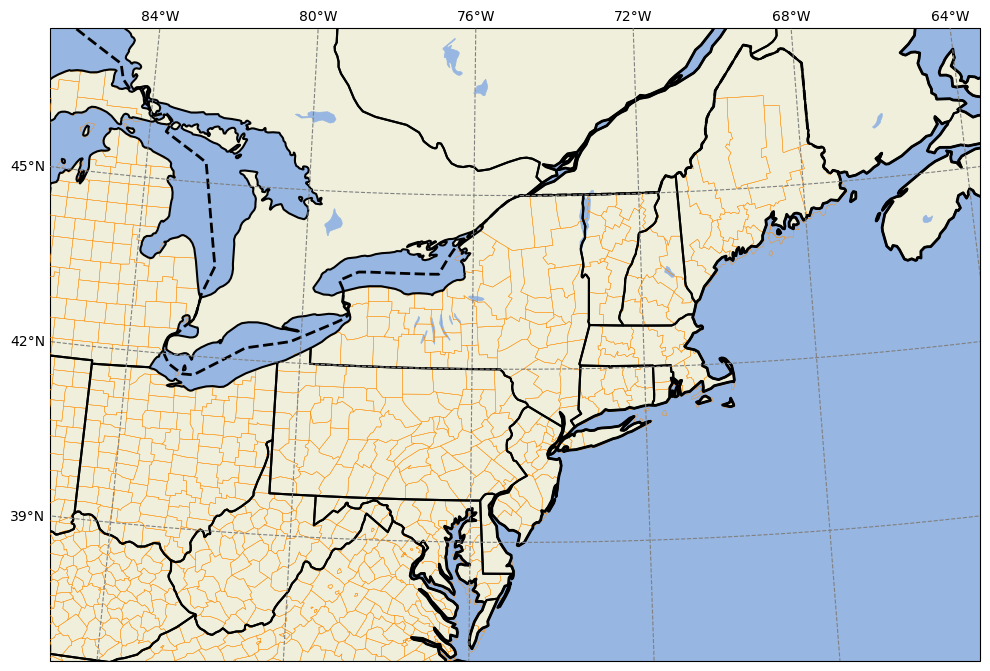

In [9]:
#Another geography example, regional map

#Select a projection from the list here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
#I typically use either LambertConformal() for CONUS/regional maps or PlateCarree() for very local maps
cart_proj=ccrs.LambertConformal(central_longitude=-75.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Download and plot geography
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#cartopy doesn't have a US counties layer, but MetPy does
ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Good extent for northeastern US plot using LambertConformal projection
ax.set_extent([-85,-65,36.5,47.5]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy for non-rectangular projections, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=5)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-100,-60,4)) #Lat/lon lines for northeastern US
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,47,3))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot some locations
#ax.plot(-82.566324, 35.615969,'*',markersize=15,color='mediumblue',label='UNCA',transform=ccrs.PlateCarree(),zorder=4)
#ax.plot(-73.8235054, 42.6860633,'*',markersize=15,color='green',label='UAlbany',transform=ccrs.PlateCarree(),zorder=4)

#Note that all plotting commands for data using lat/lon must include the transform=ccrs.PlateCarree() argument, 
#this transforms the data from lat/lon coordinates into map x/y coordinates 
#which is needed to correctly overlay the data with the geography

#ax.legend(loc='lower right')

#Try playing around with the following to get a feel for how the geography mapping works and to customize the plot
#In each of the ax.add_feature lines: geog_color, edgecolor (sets line color) on individual layers, linewidth, facecolor
#In ax.set_extent: each of the lat/lon min/max values

#plt.savefig(imgdir+'geog_neus.png',bbox_inches='tight') #Uncomment to save figure

### Simple plotting with one model variable and geographic layers

In [10]:
#View data variable names and coordinates before downloading some data (repeated from above)
ds

<xarray.Dataset>
Dimensions:                                                                   (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 1, isobaric1: 6, isobaric2: 21, isobaric3: 26, isobaric4: 2, isobaric5: 25, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1)
Coordinates:
  * lat                                                                       (lat) float32 ...
  * lon                                                                       (lon) float32 ...
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * height_above_ground_layer                                                 (height_above_ground_layer) float32 ...
  * sigma                                                                     (sigma) float32 ...
  * height_above_ground                                                       (height_above_ground) float32 ...
  * depth_below_surface_layer                                                 (depth_below_surface_layer) float32 ...
  * pressure_difference_layer                                                 (pressure_difference_layer) float32 ...
  * isobaric                                                                  (isobaric) float32 ...
  * height_above_ground1                                                      (height_above_ground1) float32 ...
  * height_above_ground2                                                      (height_above_ground2) float32 ...
  * isobaric1                                                                 (isobaric1) float32 ...
  * isobaric2                                                                 (isobaric2) float32 ...
  * altitude_above_msl                                                        (altitude_above_msl) float32 ...
  * height_above_ground3                                                      (height_above_ground3) float32 ...
  * height_above_ground_layer1                                                (height_above_ground_layer1) float32 ...
  * pressure_difference_layer1                                                (pressure_difference_layer1) float32 ...
  * isobaric3                                                                 (isobaric3) float32 ...
  * isobaric4                                                                 (isobaric4) float32 ...
  * pressure_difference_layer2                                                (pressure_difference_layer2) float32 ...
  * sigma_layer                                                               (sigma_layer) float32 ...
  * height_above_ground4                                                      (height_above_ground4) float32 ...
  * potential_vorticity_surface                                               (potential_vorticity_surface) float32 ...
  * isobaric5                                                                 (isobaric5) float32 ...
Dimensions without coordinates: depth_below_surface_layer_bounds_1, height_above_ground_layer1_bounds_1, height_above_ground_layer_bounds_1, pressure_difference_layer1_bounds_1, pressure_difference_layer2_bounds_1, pressure_difference_layer_bounds_1, sigma_layer_bounds_1
Data variables:
    LatLon_Projection                                                         int32 ...
    height_above_ground_layer_bounds  

In [11]:
#Now let's download and plot some GFS data, specifically precipitable water

#Could download entire field, but this can be slower 
#so it's a good idea to select only the data subset you need before downloading
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
#the above bounds need to be slightly larger than the areal extent of the plot so data aren't missing along the borders of the map
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

#for some reason, latitudes are listed in descending, not ascending order so I had to reverse the order of my latmin/latmax positions below

varname='Precipitable_water_entire_atmosphere_single_layer'
#Note on xarray data selection using .sel() or .isel(): isel() selects by index of data (e.g., time index 0) 
#while sel() selects by values according to listed data coordinates (e.g., latitudes from latmin to latmax) -- incredibly helpful!
#slice() function works like array semicolon (array[::]) syntax, where slice(225,305) selects data from 225-305
#print (ds[varname]) #View attributes of data selected 
pwat=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))
print (pwat) #View attributes of data selected

<xarray.DataArray 'Precipitable_water_entire_atmosphere_single_layer' (lat: 71, lon: 161)>
array([[ 4.1,  4. ,  4. , ..., 22.7, 22.7, 22.4],
       [ 4.7,  4.7,  4.8, ..., 22.7, 22.4, 22. ],
       [ 5.3,  5.3,  5.4, ..., 21.9, 21.3, 20.8],
       ...,
       [22.3, 21.9, 21.7, ..., 47.6, 47.6, 47.2],
       [22.8, 22.4, 22.2, ..., 45.1, 45.1, 45.6],
       [22.8, 22.6, 22.5, ..., 44.9, 46.1, 48.4]], dtype=float32)
Coordinates:
  * lat      (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 22.0 21.5 21.0 20.5 20.0
  * lon      (lon) float32 225.0 225.5 226.0 226.5 ... 303.5 304.0 304.5 305.0
    reftime  datetime64[ns] 2012-10-29T18:00:00
    time     datetime64[ns] 2012-10-29T18:00:00
Attributes:
    long_name:                      Precipitable water @ Entire atmosphere layer
    units:                          kg.m-2
    abbreviation:                   PWAT
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-1-3_L200
    Grib2_Parameter:          

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

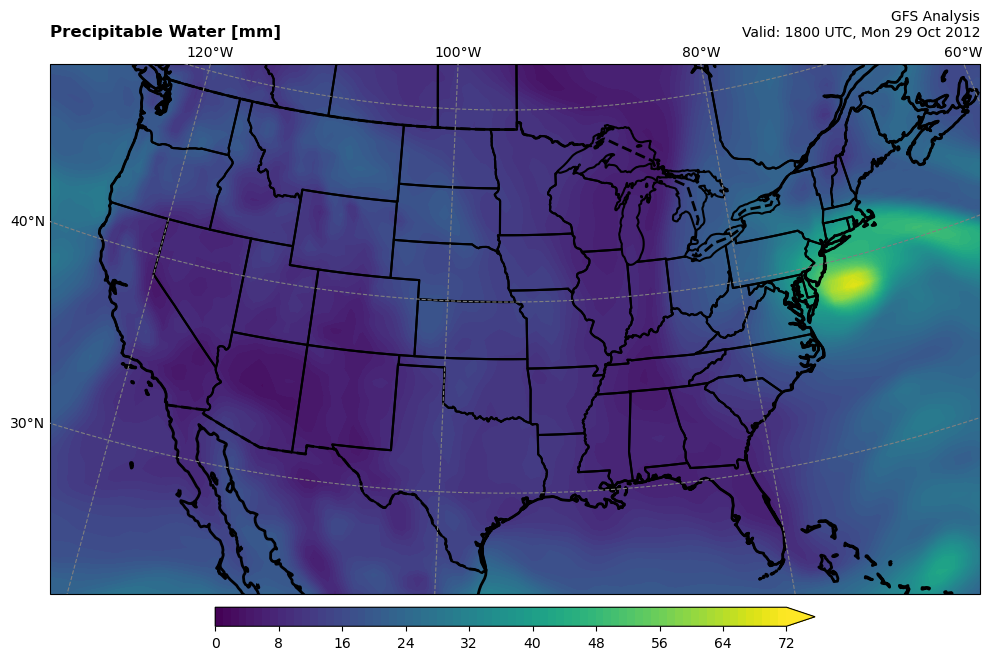

In [12]:
#Now plot the selected field, precipitable water

cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#cartopy doesn't have a US counties layer, but MetPy does
#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Good extent for CONUS plot using rectangular PlateCarree projection
#ax.set_extent([-126,-66,23,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None


#Plot precipitable water
lons=pwat.lon.values
lats=pwat.lat.values

#Fill options: pcolormesh (shows individual pixels) or contourf (smoothed contour fill)
#pc=ax.pcolormesh(lons,lats,pwat,cmap=plt.cm.viridis,transform=ccrs.PlateCarree(),zorder=2.5)
cf_levels=np.arange(0,73,1) #Contour pwat from 0-72 mm, with contours every 1 mm
pc=ax.contourf(lons,lats,pwat,levels=cf_levels,cmap=plt.cm.viridis,transform=ccrs.PlateCarree(),zorder=2.5,extend='max') #extend='max' causes pwat values above max to be the same color as the maximum color

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom

#Add plot title
fcst_time=model_init+timedelta(hours=tstep) #doesn't matter for analysis data here, but I use this to dynamically update the valid time when plotting forecast data
model_str='GFS Analysis'
fontsize=12
#Using format strings again below to create nice titles without hardcoding dates
ax.set_title('Precipitable Water [mm]',fontweight='bold',loc='left',fontsize=fontsize)
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_pwat_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

### More complex plotting with existing variables, using MetPy to do unit conversions

In [13]:
#Next example: plot 10 m winds, 2 m temperature, MSLP, and wind barbs

zlevel_wind=10 #desired height level for wind (m)
zlevel_temp=2 #desired height level for temperature (m)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)


varname='u-component_of_wind_height_above_ground'
#print (ds[varname])
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),height_above_ground3=zlevel_wind)
varname='v-component_of_wind_height_above_ground'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),height_above_ground3=zlevel_wind)
varname='Temperature_height_above_ground'
#print (ds[varname])
temp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),height_above_ground4=zlevel_temp)
varname='MSLP_Eta_model_reduction_msl'
mslp=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))
#print (mslp) #View attributes of data selected

In [14]:
#Convert xarray DataArrays to MetPy arrays with units attached, useful for unit conversions below
temperature=units.Quantity(temp.values,temp.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)
msl_pressure=units.Quantity(mslp.values,mslp.units)

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

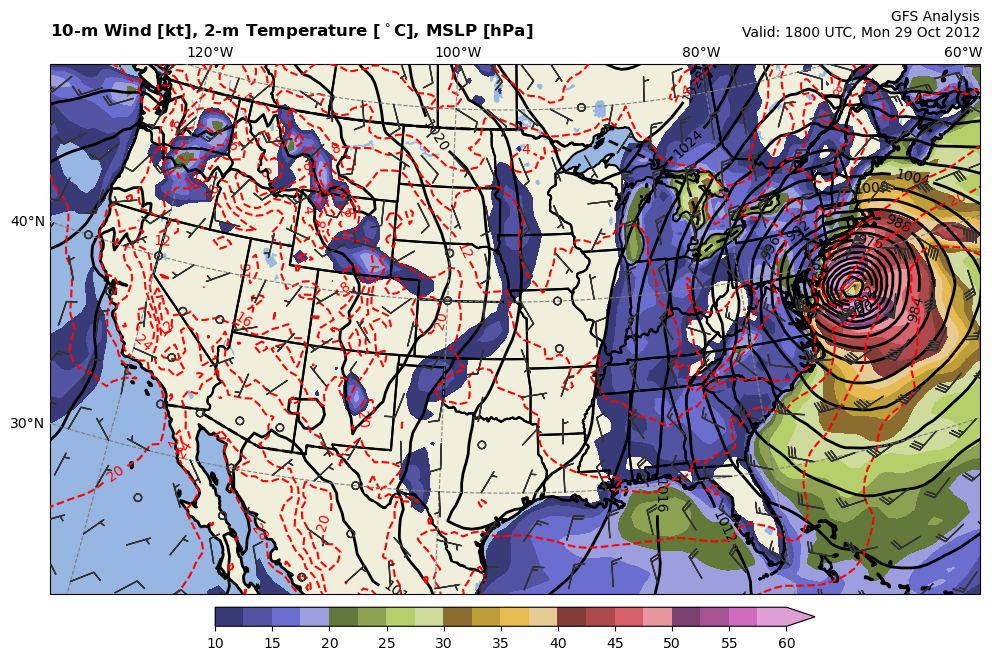

In [15]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot 10 m wind speed as fill
lons=temp.lon.values
lats=temp.lat.values

#Calculate wind speed from components, convert from m/s to knots
wspd_kts=(u_wind.to(units('kts')).magnitude**2. + v_wind.to(units('kts')).magnitude**2.)**0.5
cf_levels=np.arange(10,60.1,2.5)
pc=ax.contourf(lons,lats,wspd_kts,levels=cf_levels,cmap=plt.cm.tab20b,transform=ccrs.PlateCarree(),zorder=2.5,extend='max') #

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
cbar=plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom
cbar.set_ticks(cf_levels[::2]) #Override default tick locations for cleaner colorbar

#Also plot MSLP using solid contours
co_levels=np.arange(920,1080,4) #hPa
#Optional: I like to smooth some of these fields otherwise the contours can be jagged in some areas like the Rockies
#Set sigma=0 below to disable smoothing
sigma=2
#Convert from Pa to hPa before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(msl_pressure.to(units('hPa')),sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
                   
#Next, plot temperature using dashed contours
sigma=2 #adding some smoothing
#Convert from K to C before plotting
co_levels=np.arange(-60,61,4)
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
#Need to remove some wind barbs otherwise plot will be covered, determine interval of gridpoints to skip
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.2',zorder=4.5)
#Optional: can add "pivot='middle', regrid_shape=15" (tweak value to fit) and set skip=1 inside the end of the ax.barbs() line above
#to make barbs plot in straight lines instead of curved lines along lat/lon bands

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{zlevel_wind}-m Wind [kt], {zlevel_temp}-m '+'Temperature [$^\circ$C], MSLP [hPa]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_wind{zlevel_wind}m_temp{zlevel_temp}m_mslp_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

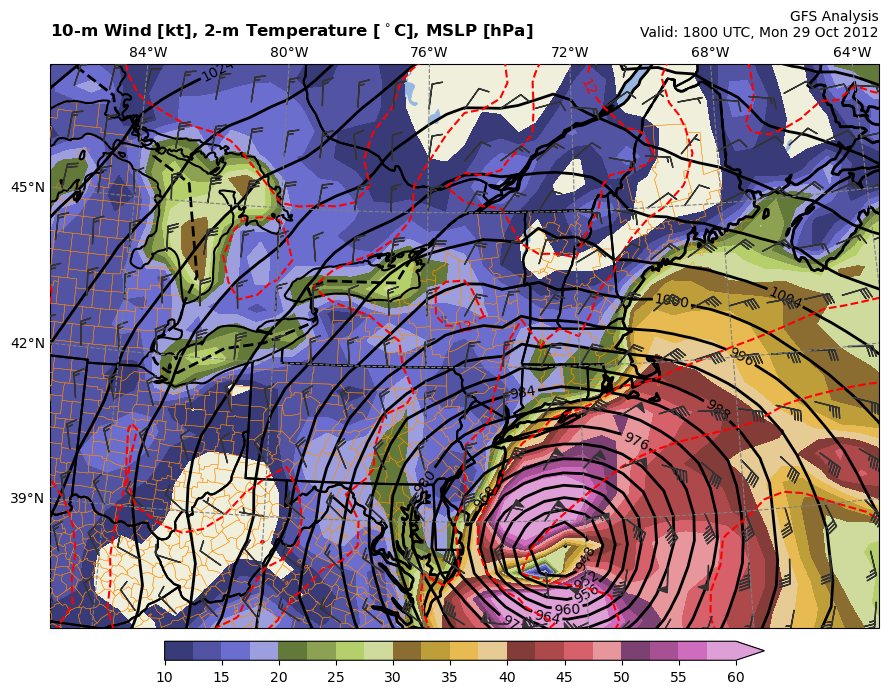

In [16]:
#Same example as above, using regional plot extent over northeastern U.S.
cart_proj=ccrs.LambertConformal(central_longitude=-75.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#cartopy doesn't have a US counties layer, but MetPy does
ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Good extent for northeastern US plot using LambertConformal projection
ax.set_extent([-85,-65,36.5,47.5]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=5)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-100,-60,4)) #Lat/lon lines for northeastern US
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,47,3))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot 10 m wind speed as fill
lons=temp.lon.values
lats=temp.lat.values

#Calculate wind speed from components, convert from m/s to knots
wspd_kts=(u_wind.to(units('kts')).magnitude**2. + v_wind.to(units('kts')).magnitude**2.)**0.5
cf_levels=np.arange(10,60.1,2.5)
pc=ax.contourf(lons,lats,wspd_kts,levels=cf_levels,cmap=plt.cm.tab20b,transform=ccrs.PlateCarree(),zorder=2.5,extend='max') #

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
cbar=plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom
cbar.set_ticks(cf_levels[::2]) #Override default tick locations for cleaner colorbar

#Also plot MSLP using solid contours
co_levels=np.arange(920,1080,4) #hPa
#Optional: I like to smooth some of these fields otherwise the contours can be jagged in some areas like the Rockies
#Set sigma=0 below to disable smoothing
sigma=2
#Convert from Pa to hPa before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(msl_pressure.to(units('hPa')),sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')
                   
#Next, plot temperature using dashed contours
sigma=2 #adding some smoothing
#Convert from K to C before plotting
co_levels=np.arange(-60,61,4)
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(temperature.to(units('degC')),sigma),levels=co_levels,colors='r',linewidths=1.5,linestyles='--',transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
#Need to remove some wind barbs otherwise plot will be covered, determine interval of gridpoints to skip
skip=2 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.2',zorder=4.5)
#Optional: can add "pivot='middle', regrid_shape=15" (tweak value to fit) and set skip=1 inside the end of the ax.barbs() line above
#to make barbs plot in straight lines instead of curved lines along lat/lon bands

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{zlevel_wind}-m Wind [kt], {zlevel_temp}-m '+'Temperature [$^\circ$C], MSLP [hPa]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_neus_wind{zlevel_wind}m_temp{zlevel_temp}m_mslp_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure

In [17]:
#Next example: plot pressure level vorticity, geopotential heights, and wind barbs

#Looks like heights, winds, and absolute vorticity are available variables in the dataset, 
#will need to calculate relative vorticity if desired

plevel=500 #desired pressure level (hPa)
lonoffset=360 #Note that THREDDS server hosts GFS data in degrees east
latmin=20
latmax=55
lonmin=-135+lonoffset
lonmax=-55+lonoffset 
tstep=0 #Forecast hour time step (pretty simple for analysis data with only one time index)

#Note: on some dates the vertical index is called "isobaric3" or "isobaric1" for certain variables,
#while other dates it is called "isobaric"
#Annoying (!), try uncommenting print (ds[varname]) below for debugging purposes
varname='u-component_of_wind_isobaric'
#print (ds[varname])
uwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='v-component_of_wind_isobaric'
vwind=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Geopotential_height_isobaric'
hgt=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
varname='Absolute_vorticity_isobaric'
avor=ds[varname].isel(time=tstep).sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax),isobaric3=plevel*100.)
#print (avor) #View attributes of data selected

In [18]:
#Convert xarray DataArrays to MetPy arrays with units attached, useful for unit conversions below
height=units.Quantity(hgt.values,hgt.units) #using 'units' attribute from xarray DataArray to give to MetPy's unit handler
u_wind=units.Quantity(uwind.values,uwind.units)
v_wind=units.Quantity(vwind.values,uwind.units)

Text(1.0, 1.0, 'GFS Analysis\nValid: 1800 UTC, Mon 29 Oct 2012')

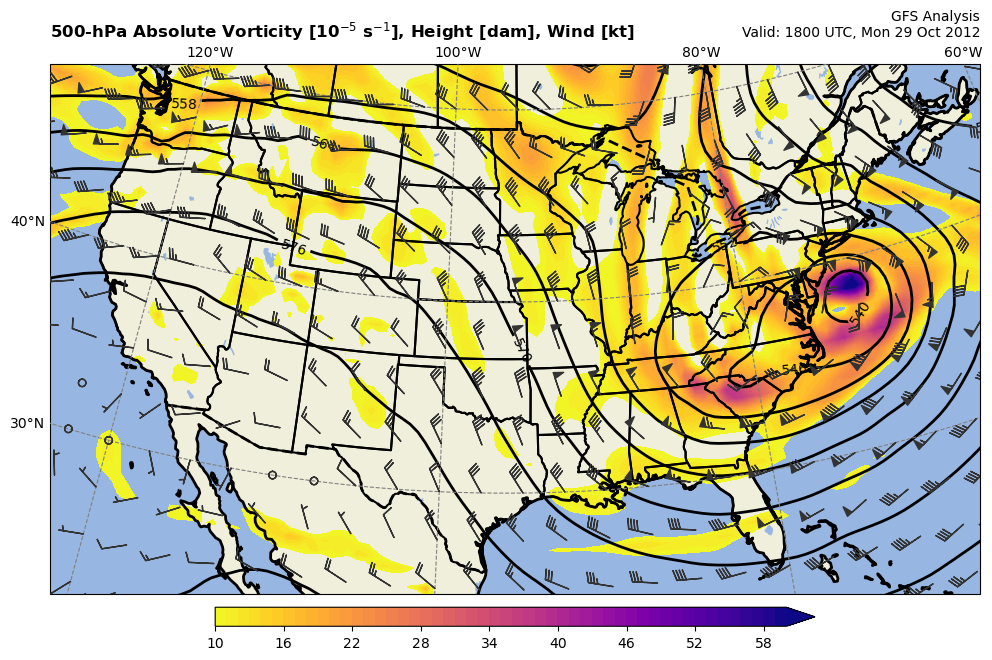

In [19]:
cart_proj=ccrs.LambertConformal(central_longitude=-96.0) #Standard projection options can be changed using arguments here
fig,ax=plt.subplots(dpi=100,figsize=(12,9),subplot_kw={'projection':cart_proj})

#Plot geography (doesn't download again after the first time it is cached)
geog_scale='50m' #Options: 10m, 50m, 110 m (fine, medium, coarse)
geog_color='k' #See options here: https://matplotlib.org/3.3.0/tutorials/colors/colors.html and https://matplotlib.org/3.3.0/gallery/color/named_colors.html
ax.add_feature(cfeature.OCEAN.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND.with_scale(geog_scale),edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,zorder=3.1,linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(geog_scale),linewidth=2.,edgecolor=geog_color,facecolor='none',zorder=3)
ax.add_feature(cfeature.STATES.with_scale(geog_scale),linewidth=1.5,edgecolor=geog_color,facecolor='none',zorder=3.1)
ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor='face',facecolor=cfeature.COLORS['water']) #Filled lakes, no outlines 
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor='none',zorder=3) #Lake outlines only
#ax.add_feature(cfeature.LAKES.with_scale(geog_scale),linewidth=0.5,edgecolor=geog_color,facecolor=cfeature.COLORS['water'],zorder=3) #Lake outlines with fill
#ax.add_feature(cfeature.RIVERS.with_scale(geog_scale),linewidth=2.0) #Filled rivers, no outlines 

#ax.add_feature(USCOUNTIES.with_scale('20m'),edgecolor='darkorange',zorder=2.9,linewidth=0.3) #US counties

#Good extent for CONUS plot using LambertConformal projection
ax.set_extent([-121,-70,22,50]) #lonmin, lonmax, latmin, latmax of plot extent

#Optional: plot lat/lon lines (only recently available in cartopy, need cartopy version 0.18+)
gl=ax.gridlines(draw_labels=True, dms=True,x_inline=False,y_inline=False,linestyle='--',color='0.5',zorder=4)
gl.xlocator=mpl.ticker.FixedLocator(np.arange(-120,59,20)) #Lat/lon lines for CONUS
gl.ylocator=mpl.ticker.FixedLocator(np.arange(30,51,10))
gl.bottom_labels=False
gl.right_labels=False
gl.rotate_labels=None

#Plot vorticity as fill
lons=avor.lon.values
lats=avor.lat.values

cf_levels=np.arange(10,61,1) #Going to multiply data by 10^5 for simpler plotting
pc=ax.contourf(lons,lats,avor.values*1e5,levels=cf_levels,cmap=plt.cm.plasma_r,transform=ccrs.PlateCarree(),zorder=2.5,extend='max') #

#plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30) #vertical colorbar on right
plt.colorbar(pc,shrink=0.645,pad=0.02,aspect=30,orientation='horizontal') #horizontal colorbar at bottom

#Also plot geopotential height contours
if int(plevel)>500:
    co_levels=np.arange(0,390,3) #decameters (dam)
else:
    co_levels=np.arange(420,996,6) #dam

sigma=5 #Doing relatively large smoothing so height contours are not jagged 
#Convert from meters to decameters before plotting
cont=ax.contour(lons,lats,mpcalc.smooth_gaussian(height.to(units('dam')),sigma),levels=co_levels,colors='k',linewidths=2.0,transform=ccrs.PlateCarree(),zorder=4)
plt.clabel(cont,inline=1,fontsize=10,fmt='%i')

#Finally, plot wind barbs
#Need to remove some wind barbs otherwise plot will be covered, determine interval of gridpoints to skip
skip=5 #set skip=1 to plot all gridpoints
#Convert wind from m/s to knots
ax.barbs(lons[::skip],lats[::skip],u_wind.to(units('kts')).magnitude[::skip,::skip],v_wind.to(units('kts')).magnitude[::skip,::skip],transform=ccrs.PlateCarree(),length=6,color='0.2',zorder=4.5)

#Add plot title
fcst_time=model_init+timedelta(hours=tstep)
model_str='GFS Analysis'
fontsize=12
ax.set_title(f'{plevel}-hPa '+'Absolute Vorticity [10$^{-5}$ s$^{-1}$], Height [dam], Wind [kt]',fontweight='bold',loc='left',fontsize=fontsize) #Can use some LaTeX math notation (within $$ commands) for nice formatting of labels
#ax.set_title(f'{model_str}, Init: {model_init:%H%M UTC, %d %b %Y}\n f{tstep}, Valid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
ax.set_title(f'{model_str}\nValid: {fcst_time:%H%M UTC, %a %d %b %Y}',fontsize=fontsize-2,loc='right') #\n is a newline command, I use it to wrap text here
#plt.savefig(imgdir+f'gfs_anl_conus_avor{plevel}_{fcst_time:%Y%m%d_%H%M}.png',bbox_inches='tight') #Uncomment to save figure